<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_HD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-im8kw0hh
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-im8kw0hh
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.04c42ce20a2fbc4b0aad83bfa86ba776b05826847_-cp36-none-any.whl size=119801 sha256=e78e2ec2e7a1fc82b4b1d0585d6f3a345ab7d8e0e672133b9000a19b4b7e205f
  Stored in directory: /tmp/pip-ephem-wheel-cache-bjvn2dm0/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [59]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/HD/df_HD_20drtn_features.csv')

In [60]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,33.273523,32.412259,38.791552,50.752320,-98.938968,-98.938968,-98.938968,-72.777019,47.057445,49.687787,53.416634,64.308843,-3.736921,-4.909560,-7.037167,-5.951074,-6.835441,-0.212878,-0.024364,0.063097,0.060827,-0.327347,-0.327347,-0.327347,-0.327347,-166.666667,-116.736304,-166.404656,-165.203019,-6.967575,-26.792280,0.034484,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.431962,0.073251,0.360740,-0.033553,0.441744,0.004012,27.549999,2.949999,4.019999,-6.995601e+06,-6.995601e+06,-6.995601e+06,-6.995601e+06,-0.005961,-0.050753,-0.072069,0.068614,-0.217818,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,37.280452,34.016390,41.107161,52.413276,-83.758725,-83.758725,-83.758725,-77.265990,46.846870,50.068898,48.201435,64.967496,0.465834,-3.684413,-2.523541,-6.805910,-8.873241,-0.272228,-0.060024,0.040925,0.058398,-0.412502,-0.412502,-0.412502,-0.412502,-106.079376,-108.758878,-157.196040,-173.391862,-12.155987,-24.063469,0.564515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.422597,0.032900,0.344048,-0.034957,0.441794,-0.001977,27.490000,-0.059999,0.949999,-4.047336e+06,-4.047336e+06,-4.047336e+06,-4.047336e+06,-0.059449,-0.001149,-0.071506,0.053046,0.074204,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,27.830263,33.449734,32.915891,50.503481,-99.116978,-99.116978,-99.116978,-92.966374,36.714263,50.049376,48.262477,63.045529,-3.400306,-6.576981,-7.715025,-13.254683,-10.618518,-0.344489,-0.101790,0.015074,0.054995,-0.544718,-0.544718,-0.544718,-0.544718,-110.699558,-126.288593,-160.127742,-199.889918,-22.625967,-26.417273,0.040405,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.359913,-0.047501,0.358079,-0.033057,0.447264,0.001926,29.379999,1.889999,3.099998,-7.740267e+06,-7.740267e+06,-7.740267e+06,-7.740267e+06,-0.255822,-0.095404,-0.099260,0.026182,0.115424,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,31.312635,43.131959,42.151130,51.884146,-71.028003,-72.626899,-72.626899,-74.617735,32.619315,51.131879,49.219280,65.247563,4.800003,1.708077,-2.493487,-9.122439,-8.678981,-0.390044,-0.137330,-0.009120,0.051289,-0.546372,-0.546372,-0.546372,-0.546372,-19.276538,-73.616599,-94.801555,-138.386442,-31.331715,-26.696092,0.978725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.474065,0.066430,0.390925,0.016562,0.459072,0.022075,26.360001,-3.019999,0.840000,3.687748e+06,3.687748e+06,3.687748e+06,3.687748e+06,-0.143290,0.016798,-0.063637,0.067529,0.286873,2.156,0.018,0.172,0.290001,-0.380005,1.0
4,2008-03-12,29.448473,43.240159,37.388015,52.870652,-68.716590,-74.172188,-74.172188,-77.102815,33.011194,52.121066,49.323452,65.462793,-0.267182,0.965997,-2.354264,-9.616052,-7.928119,-0.416327,-0.167450,-0.031693,0.047310,-0.547025,-0.547025,-0.547025,-0.547025,117.563734,-10.805826,-50.144166,-85.969471,-40.913840,-28.408955,0.137931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471018,0.073669,0.390179,0.050553,0.454403,0.018686,27.219999,0.859999,2.619999,1.991613e+06,1.991613e+06,1.991613e+06,1.991613e+06,-0.235324,-0.064833,-0.071630,0.034890,-0.095430,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [61]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [62]:
from_date='2010-01-01'
to_date='2020-01-01'

In [63]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [64]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,52.366406,63.211655,59.967230,67.238696,-48.695788,-48.695788,-27.860762,-15.384648,42.359271,49.882517,52.846868,63.083619,0.732470,-0.858222,-1.028105,0.802791,2.849000,0.208952,0.240424,0.213821,0.106209,0.366151,0.366151,0.366151,0.366151,-97.156326,-167.186738,-124.539113,19.149233,66.028390,75.147498,0.842856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.128150,-0.000102,0.155188,-0.026173,0.182150,-0.025160,19.350000,-0.690001,-0.580000,1.122228e+05,1.122228e+05,1.122228e+05,1.122228e+05,0.052418,-0.053627,0.010872,0.141374,0.188508,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,52.802543,54.687514,57.289601,64.554536,-57.391310,-57.391310,-32.835810,-20.370367,41.580849,49.054072,52.106609,62.753601,-0.346255,-0.518492,-1.674068,-0.621541,1.984413,0.181132,0.228815,0.210742,0.108532,0.330526,0.330526,0.330526,0.330526,-34.782410,-89.685894,-75.605012,28.822884,60.522890,70.109745,0.266667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116499,0.003221,0.155533,-0.020311,0.178947,-0.008133,19.160000,-0.190001,-0.850000,-2.196203e+05,-2.196203e+05,-2.196203e+05,-2.196203e+05,0.015682,-0.105447,-0.028531,0.131603,-0.433562,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,54.540854,54.580151,59.219718,64.234751,-27.826070,-27.826070,-15.920381,-10.355977,41.701254,47.436107,58.098428,62.741538,1.181376,1.569588,-0.034323,-0.580403,5.240335,0.161286,0.218420,0.207575,0.110751,0.325970,0.325970,0.325970,0.325970,72.829059,8.130019,12.980228,55.680385,56.525120,65.874376,0.795921,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117718,0.002740,0.139641,-0.021636,0.168367,-0.019563,19.059999,-0.100000,-0.900000,1.220183e+06,1.220183e+06,1.220183e+06,1.220183e+06,0.037819,-0.103019,0.039616,0.124994,0.365100,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,41.718450,49.158233,64.291466,60.710390,-40.000100,-40.000100,-27.381006,-14.886763,39.195547,38.086165,57.140636,59.952077,-0.480774,0.346262,0.172828,-0.068967,5.190564,0.143606,0.207876,0.203801,0.112790,0.307518,0.307518,0.307518,0.307518,66.326539,-13.618710,-8.818547,44.150851,53.202148,62.206367,0.527272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108840,-0.011424,0.139961,-0.019935,0.169215,-0.020004,18.129999,-0.930000,-3.550001,8.499131e+04,8.499131e+04,8.499131e+04,8.499131e+04,0.073615,-0.031136,0.053802,0.118122,0.294538,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,31.892821,38.638955,55.354482,56.027654,-94.117655,-94.117655,-94.117655,-41.423968,29.332857,35.423513,49.508173,56.067432,-2.829537,-2.154277,-1.778864,-3.462462,0.607360,0.110601,0.191599,0.196947,0.114291,0.224144,0.224144,0.224144,0.224144,-139.639601,-177.777764,-201.754395,-54.801590,46.411107,54.568993,0.085106,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.173041,0.047256,0.168947,0.014588,0.180277,-0.011181,17.549999,-0.580000,-2.490002,-6.413273e+06,-6.413273e+06,-6.413273e+06,-6.413273e+06,-0.122164,-0.088859,-0.048538,0.071677,0.516387,3.793,0.025,0.007,-0.470001,-0.529999,1.0


In [65]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,73.902196,46.837289,50.482528,41.830019,-3.467196,-3.467196,-17.601208,-63.135878,81.211993,64.688916,60.346932,50.993363,0.440469,1.593791,3.321189,3.224754,1.212597,-0.190937,-0.249598,-0.196968,0.013096,-2.303096,-2.303096,-2.303096,-2.303096,107.878280,129.562634,148.206349,22.818618,-64.969088,-66.935184,0.785308,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.140815,-0.023507,0.148699,-0.096579,0.200130,0.004287,12.51,0.010000,-0.120000,7.667721e+06,7.667721e+06,7.667721e+06,7.667721e+06,0.122006,-0.006725,0.106241,-0.017536,0.439075,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,62.960950,47.338737,50.807962,41.186656,-24.495114,-24.495114,-33.021740,-70.034819,74.906816,65.009800,61.230487,50.607233,-0.895156,0.555049,1.707423,1.237707,0.541214,-0.146248,-0.231330,-0.192950,0.008106,-2.010767,-2.010767,-2.010767,-2.010767,47.619029,84.588264,119.034028,26.810434,-59.339508,-61.934838,0.024478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146381,-0.013637,0.152269,-0.094917,0.200833,0.004480,12.61,0.099999,0.469999,2.508977e+06,2.508977e+06,2.508977e+06,2.508977e+06,0.047491,-0.003628,0.108673,-0.038294,-0.492980,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,78.691700,62.711371,48.778732,41.177749,-17.917021,-17.822642,-26.415097,-67.386754,86.382623,76.361710,60.186292,50.504186,-0.384932,0.346697,-0.113523,3.739864,-1.358744,-0.034714,-0.171180,-0.172649,-0.004614,-1.125572,-1.125572,-1.125572,-1.125572,16.933219,61.128681,80.420615,73.450491,-40.109517,-44.381131,0.094529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101721,-0.039703,0.144708,-0.008506,0.196464,-0.003179,13.43,0.780001,0.850000,4.472247e+05,4.472247e+05,4.472247e+05,4.472247e+05,0.124859,0.034664,-0.061002,-0.044403,0.163672,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,65.032567,58.394450,41.597003,38.278239,-60.909147,-41.176494,-41.176494,-76.655060,77.614870,71.576982,59.649195,50.289102,-1.209257,-1.522636,-1.754150,1.508780,-1.451180,-0.017724,-0.154725,-0.165616,-0.008364,-1.170238,-1.170238,-1.170238,-1.170238,-166.666667,-50.646488,17.904981,16.695709,-36.132547,-40.986844,0.192892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122577,-0.018238,0.145637,-0.003062,0.197757,-0.002373,14.82,1.389999,2.320000,-3.206316e+06,-3.206316e+06,-3.206316e+06,-3.206316e+06,-0.045023,0.029801,-0.059531,-0.051035,0.282081,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,64.348076,58.623139,46.875712,39.943370,-59.053707,-31.782224,-31.782224,-72.926812,68.681663,66.528548,60.010900,48.851727,0.492388,-1.104973,-0.378633,1.322325,0.349237,-0.006791,-0.139984,-0.158651,-0.011897,-1.106540,-1.106540,-1.106540,-1.106540,-92.773634,-96.290986,6.735556,8.803723,-32.018779,-37.682421,0.937203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120697,-0.025684,0.139169,-0.013100,0.195450,-0.005384,13.78,-1.040000,1.270000,-7.858040e+05,-7.858040e+05,-7.858040e+05,-7.858040e+05,0.021295,0.053646,0.008607,-0.044430,-0.041114,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [66]:
df.drop(['timestamp'], inplace=True, axis=1)

In [67]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [68]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,65.736231,59.610113,54.744157,52.188998,-1.201655,-7.730711,-7.730711,-14.543172,55.472699,59.673664,59.283927,59.789182,1.179865,3.212399,4.469762,2.247380,4.177590,0.005533,-0.013325,-0.000168,0.044120,0.262545,0.262545,0.262545,0.262545,121.063756,186.245189,177.143476,199.877747,-2.319932,-3.388848,0.934780,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.206283,-0.009211,0.213736,-0.035808,0.273936,0.009361,19.540001,-1.400000,-8.089998,4.118892e+06,4.118892e+06,4.118892e+06,4.118892e+06,0.245629,0.110158,0.101488,0.056871,0.038740,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,22.014682,28.238548,28.553712,52.149181,-50.243442,-70.256122,-76.730423,-76.730423,32.937789,28.899909,30.663571,50.336667,0.261849,-0.483422,-0.088716,-1.704578,-7.085662,-0.273796,-0.080054,0.045255,0.129143,-2.030462,-2.030462,-2.030462,-2.030462,-128.348895,-112.920219,-95.621853,-105.738266,-30.038723,-20.476845,0.826860,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129127,-0.075299,0.162869,-0.005536,0.164139,-0.009320,14.950000,-1.360000,-3.110000,-2.635697e+05,-2.635697e+05,-2.635697e+05,-2.635697e+05,0.106490,0.011940,0.015753,0.096543,0.788827,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,60.484222,64.498044,58.640559,55.887978,-47.515590,-42.500045,-23.111819,-23.111819,78.453626,78.820693,71.796425,62.799671,-2.955406,0.221970,-2.007601,3.052781,9.887436,0.452817,0.297178,0.188051,-0.026187,0.829582,0.829582,0.829582,0.829582,-33.178579,36.765143,69.392371,98.898160,76.206428,77.664659,0.078261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.355212,0.063424,0.325479,0.016188,0.305188,0.014379,24.530001,-0.929998,-6.789999,-2.451338e+06,-2.451338e+06,-2.451338e+06,-2.451338e+06,-0.023919,0.053390,0.105304,0.106705,0.196924,2.296,-8.899999e-02,0.108,0.219994,-1.210007,1.0
765,57.805694,53.451955,62.569784,49.486970,-42.537286,-33.529454,-30.158724,-18.506496,67.603989,64.304880,65.618032,49.237104,0.450088,-0.602566,0.716752,1.173330,3.604587,0.124017,0.084461,0.064163,0.121814,0.249202,0.249202,0.249202,0.249202,71.240017,144.680671,174.124996,109.965543,23.454597,19.816927,0.149252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109581,-0.020156,0.179672,0.001074,0.182450,-0.008035,15.070000,-0.760000,-1.850000,4.417919e+05,4.417919e+05,4.417919e+05,4.417919e+05,0.118391,0.097162,0.081254,0.033894,0.265417,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,0.0
1100,81.371744,80.185934,64.109535,62.414379,-14.739950,-9.444481,-8.542748,-6.882620,83.150091,74.130347,64.422586,59.940802,-0.509131,0.052964,0.176769,7.288903,6.422532,0.457665,0.294041,0.199127,0.104830,1.314085,1.314085,1.314085,1.314085,60.263466,60.003560,70.873607,103.812691,75.695170,74.706288,0.378786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209183,0.011440,0.196716,-0.034759,0.197010,-0.009944,16.350000,1.170000,2.330000,5.107140e+05,5.107140e+05,5.107140e+05,5.107140e+05,0.252656,0.300674,0.100437,0.159990,0.238589,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [69]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [70]:
train_labels.head()

1856    1.0
2747    1.0
898     1.0
765     0.0
1100    1.0
Name: labels, dtype: float64

In [71]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [72]:
get_sample_weights(train_labels)

real class weights are [1.51468315 0.74638233] [0 1]
value_counts (array([0, 1]), array([ 647, 1313]))


1856    0.746382
2747    0.746382
898     0.746382
765     1.514683
1100    0.746382
          ...   
2051    0.746382
1301    0.746382
2192    0.746382
1640    0.746382
2882    0.746382
Name: labels, Length: 1960, dtype: float64

In [73]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.51468315 0.74638233] [0 1]
value_counts (array([0, 1]), array([ 647, 1313]))


In [74]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [75]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [76]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_15',
 'rsi_20',
 'rsi_40',
 'mfi_15',
 'mfi_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'bb_h40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'vix_5d_change',
 'cmf_10',
 'dollarix_1d_change',
 'dollarix_5d_change')

In [77]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_40',
 'mfi_10',
 'mfi_40',
 'roc_1',
 'roc_20',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_25',
 'kst_20',
 'kst_40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'vix_5d_change',
 'curve')

In [78]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_40,mfi_10,mfi_40,roc_1,roc_20,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_25,kst_20,kst_40,realised_vol_10,realised_vol_20,realised_vol_40,vix_5d_change,curve
445,1.187653,-0.627843,1.039888,0.529120,0.187505,0.846651,0.822325,0.196899,-0.119023,-0.119023,-0.119023,-0.119023,-0.127592,0.951396,1.067662,-0.641135,-0.431841,-0.119599,-0.194993,2.013397
448,0.525368,-0.799319,0.687382,-0.458380,0.622293,0.669608,0.758371,0.261195,-0.156721,-0.156721,-0.156721,-0.156721,0.096801,0.679773,0.802848,-0.879503,-0.648167,-0.341406,-1.176824,2.093196
452,-0.106754,-1.107803,0.075951,0.424828,-0.802192,0.226454,0.507115,0.291628,-0.317139,-0.317139,-0.317139,-0.317139,-1.065354,0.093885,0.190696,0.023695,-0.498704,-0.161422,-0.475989,2.006838
469,-0.002378,0.321660,0.230271,0.730077,0.126659,-0.672128,-0.477066,0.027339,-0.345527,-0.345527,-0.345527,-0.345527,0.484684,-0.805683,-0.742894,1.210540,0.657876,0.193651,1.490979,1.836308
470,-0.280505,-0.059397,-0.059742,-0.687313,0.103125,-0.629204,-0.478129,0.009768,-0.330412,-0.330412,-0.330412,-0.330412,0.223009,-0.753317,-0.707145,1.287751,0.666173,0.128388,1.252959,1.902990


In [79]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [80]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [81]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.40643615, 0.59356385],
       [0.43893042, 0.56106955],
       [0.35008654, 0.6499135 ],
       [0.4380601 , 0.5619399 ],
       [0.49853772, 0.5014623 ],
       [0.36744645, 0.6325536 ],
       [0.42486665, 0.5751333 ],
       [0.3366944 , 0.6633056 ],
       [0.45412996, 0.54587   ],
       [0.4360389 , 0.5639611 ]], dtype=float32)

In [82]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
67/79 [========================>.....] - ETA: 0s - loss: 0.7500 - accuracy: 0.5149
Epoch: 0, accuracy:0.5115,  loss:0.7438,  val_accuracy:0.4566,  val_loss:0.6803,  
79/79 [==============================] - 0s 4ms/step - loss: 0.7438 - accuracy: 0.5115 - val_loss: 0.6803 - val_accuracy: 0.4566
Epoch 2/200
79/79 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.5300 - val_loss: 0.6811 - val_accuracy: 0.4184
Epoch 3/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5383 - val_loss: 0.6814 - val_accuracy: 0.4031
Epoch 4/200
79/79 [==============================] - 0s 3ms/step - loss: 0.6887 - accuracy: 0.5402 - val_loss: 0.6754 - val_accuracy: 0.5357
Epoch 5/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.5376 - val_loss: 0.6688 - val_accuracy: 0.6556
Epoch 6/200
79/79 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.5548 - val_loss: 0.6623 - val_accur

In [83]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.414604,0.823342,0.435128,0.826531,195
196,0.385142,0.815689,0.446842,0.826531,196
197,0.406742,0.806122,0.434706,0.816327,197
198,0.395041,0.810587,0.431693,0.811224,198
199,0.405575,0.816327,0.433564,0.801020,199


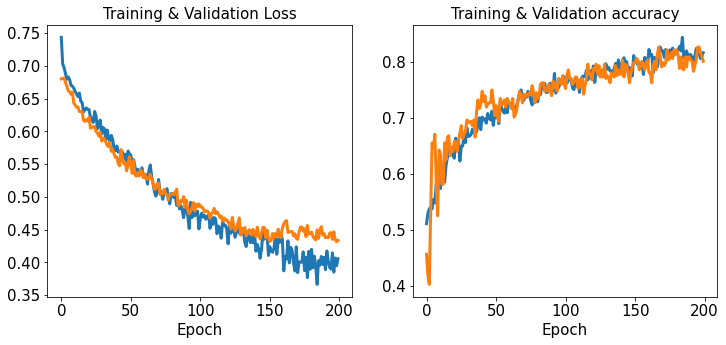

In [84]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 7.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394139 sha256=7987d49e5a28f43c4c286a806d09fde1e5b3c0d97d14124f9ecc3f27625473c0
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [85]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [86]:
shap_values  = explainer.shap_values(np.array(X_test_new))

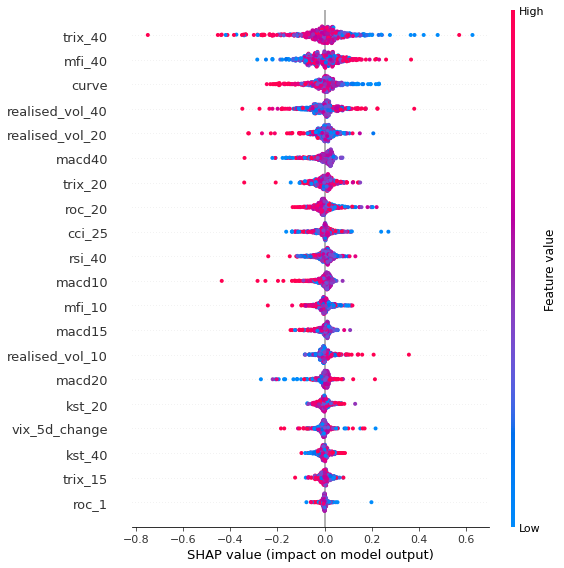

In [87]:
shap.summary_plot(shap_values[1], X_test_new)

In [88]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

In [89]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


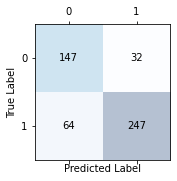

In [90]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [91]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.885
Recall: 0.794
F1: 0.837


In [92]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [93]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [94]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [10,20,30,40],
  }
]

In [95]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [96]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [97]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [98]:
model = grid.fit(normed_train_data, train_labels)

Fitting 5 folds for each of 672 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2446 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed: 26.7min finished


In [99]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/HD/xgb_HD_log_reg.pickle', "wb"))

In [100]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9338443090731416
Accuracy: 0.8816326530612245


Confusion Matrix


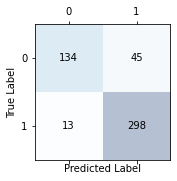

In [101]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [102]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function mutual_info_classif at 0x7fedf81f00d0>}


In [103]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.1)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.204592	validation_0-logloss:0.656316	validation_1-error:0.320408	validation_1-logloss:0.671886
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.170918	validation_0-logloss:0.631493	validation_1-error:0.285714	validation_1-logloss:0.657913
[2]	validation_0-error:0.139286	validation_0-logloss:0.593482	validation_1-error:0.257143	validation_1-logloss:0.632105
[3]	validation_0-error:0.105102	validation_0-logloss:0.553899	validation_1-error:0.210204	validation_1-logloss:0.601766
[4]	validation_0-error:0.105102	validation_0-logloss:0.535593	validation_1-error:0.234694	validation_1-logloss:0.59151
[5]	validation_0-error:0.110714	validation_0-logloss:0.513559	validation_1-error:0.226531	validation_1-logloss:0.579999
[6]	validation_0-error:0.10102	validation_0-logloss:0.487349	validation_1-error:0.222449	validation_1-logloss:0.5617

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [104]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.33%


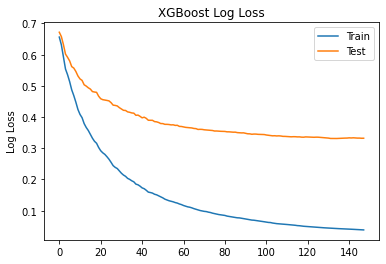

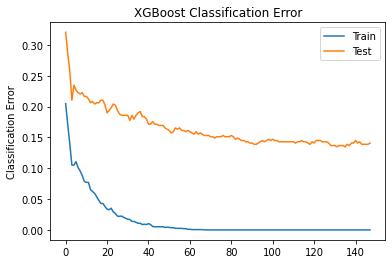

In [105]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [106]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


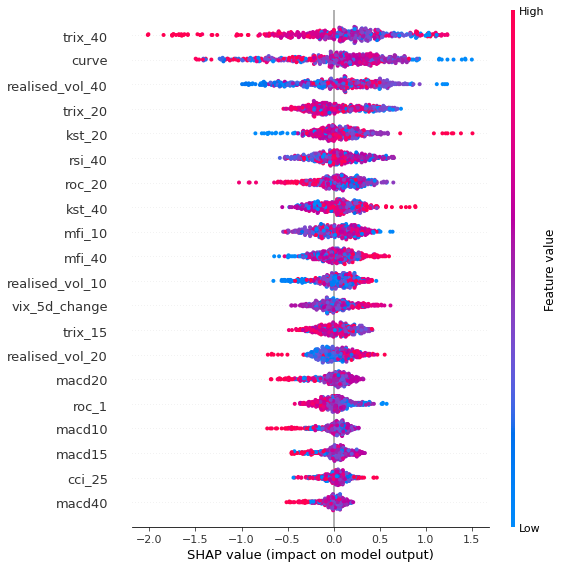

In [107]:
shap.summary_plot(shap_values, X_test_new)

In [108]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


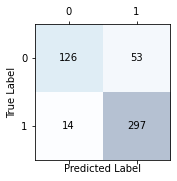

In [109]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()